In [24]:
import os

In [25]:
import sys
sys.path.append('src/other_functions')

In [408]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style("white")

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

import joblib

In [27]:
# Jack's module
import helper_functions as hf

In [28]:
# Own modules
import features as ft
import customplots as cp

# Binary classification

In [29]:
df_train = pd.read_csv('data/input/MultiClass_Train_index.csv')
df_test = pd.read_csv('data/input/MultiClass_Test.csv')

print(df_train.shape)
print(df_test.shape)

print('in train not in test')
print([i for i in df_train.columns if i not in [i for i in df_test.columns]])

print('in test not in train')
print([i for i in df_test.columns if i not in [i for i in df_train.columns]])

(61006, 14)
(13073, 13)
in train not in test
['Cover_Type']
in test not in train
[]


In [5]:
print(df_test.info())
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Index                  13073 non-null  int64
 1   Elevation              13073 non-null  int64
 2   Aspect                 13073 non-null  int64
 3   Slope                  13073 non-null  int64
 4   Horiz_dist_hydro       13073 non-null  int64
 5   Vertical_dist_hydro    13073 non-null  int64
 6   Horiz_dist_roadways    13073 non-null  int64
 7   Hillshade_9am          13073 non-null  int64
 8   Hillshade_Noon         13073 non-null  int64
 9   Hillshade_3pm          13073 non-null  int64
 10  Horiz_dist_firepoints  13073 non-null  int64
 11  Wilderness_Area        13073 non-null  int64
 12  Soil_Type              13073 non-null  int64
dtypes: int64(13)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61006 entries, 0 to 61005
Data columns (total 1

No missing data

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64


<AxesSubplot:ylabel='Cover_Type'>

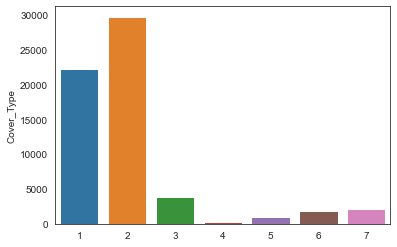

In [7]:
# Target variable
target_values = df_train['Cover_Type'].value_counts()
print(target_values)
sns.barplot(x=target_values.index, y=target_values)

In [30]:
# Only one data frame
df_train['From'] = 'train'
df_test['From'] = 'test'
df = pd.concat([df_train, df_test], axis=0)
print(df.shape)
df.head()

(74079, 15)


,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type,From
0,0,3202,34,10,0,0,2760,219,218,134,1734,1.0,3,38,train
1,1,3113,251,13,192,40,5600,191,249,195,2555,2.0,1,22,train
2,2,2801,77,9,510,17,1728,232,223,122,1087,2.0,1,12,train
3,3,3165,82,9,319,56,4890,233,225,124,1452,1.0,1,29,train
4,4,3048,333,11,124,31,2823,196,226,170,666,1.0,1,23,train


In [9]:
# Data exploration

In [7]:
df.nunique()

Index                    74079
Elevation                 1739
Aspect                     361
Slope                       58
Horiz_dist_hydro           472
Vertical_dist_hydro        566
Horiz_dist_roadways       5268
Hillshade_9am              189
Hillshade_Noon             161
Hillshade_3pm              251
Horiz_dist_firepoints     5111
Cover_Type                   7
Wilderness_Area              4
Soil_Type                   39
From                         2
dtype: int64

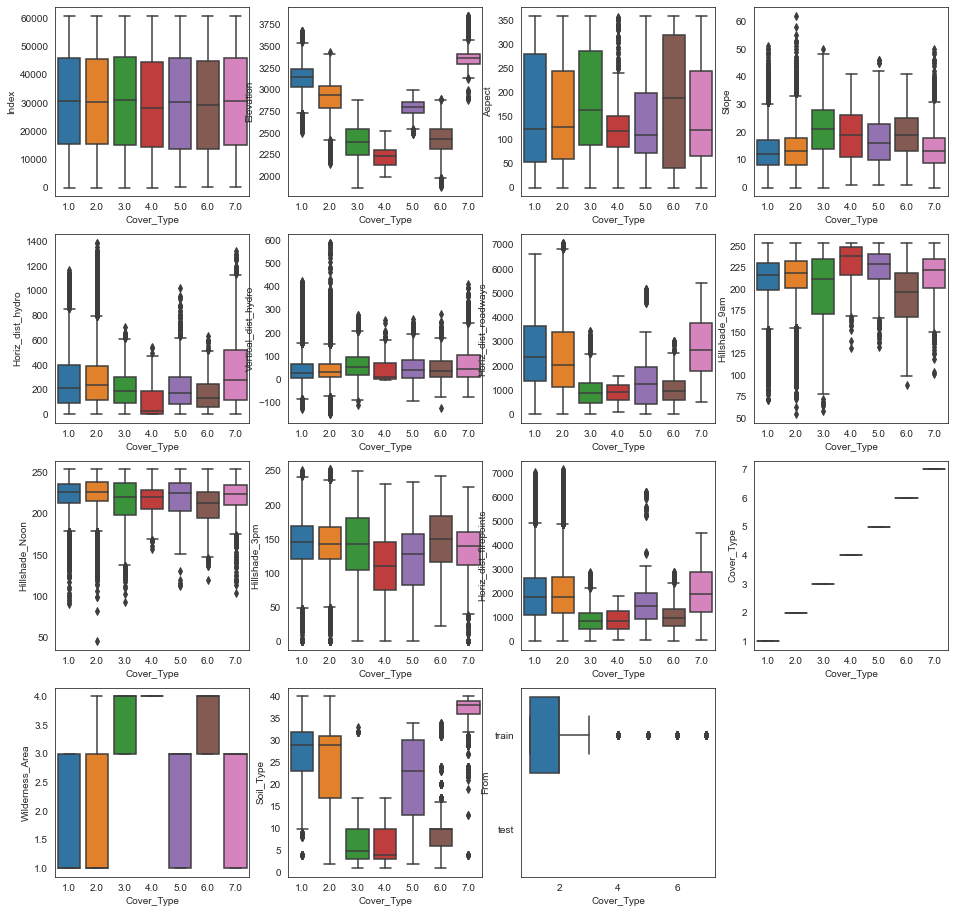

In [12]:
cp.target_features_plot(df, 'Cover_Type', df.columns, 'boxplot')

In [31]:
# Create the lable to predict (binary task)
print(df['Cover_Type'].value_counts())
df['target'] = np.where(df['Cover_Type'].isin([1,2,3,4,5,6]),0,
                       np.where(df['Cover_Type']==7,1,np.nan))
# Clean observations of test 
print(df['target'].value_counts())

2.0    29690
1.0    22199
3.0     3802
7.0     2163
6.0     1865
5.0      992
4.0      295
Name: Cover_Type, dtype: int64
0.0    58843
1.0     2163
Name: target, dtype: int64


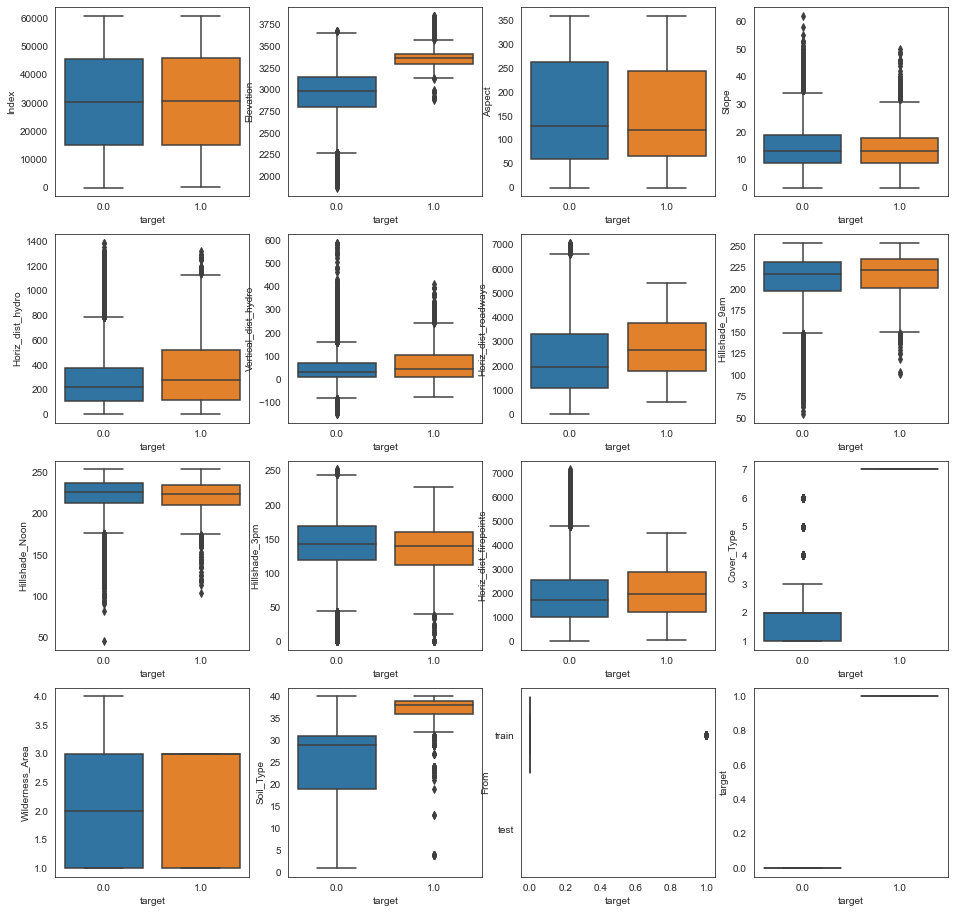

In [7]:
cp.target_features_plot(df, 'target', df.columns, 'boxplot')

## Model 1

In the in-class predictions I only created the dummy variables for the two categorical columns ('Wilderness_Area', 'Soil_Type']), ran the logit with default parameters and solve the imbalance class by using the balance property in sklearn and by applying the function to re-scale probability. In this new predictions I want to create new features and doing grid search.

From the matrix of graphs above, we can see that the distribution of the features elevation, Horiz_dist_roadways and Soil_Type is differente between our binary target. This finding is curious specially with Soil_Type which according to the source of the information is a categorical variable.

There are also, slight differences in the median between groups of our target variables in other variables like Aspect, Horiz_dist_roadways, Vertical_dist_hydro, Horiz_dist_firepoints.

In [32]:
# Index as index
df.set_index('Index', inplace=True)

In [33]:
# New data set y deleting the cover type
df2 = df.copy()
df2.drop('Cover_Type', axis=1, inplace=True)

# Soil type twice, one for using as numeric (N) and the other one to create dummies
df2['Soil_Type_N'] = df2['Soil_Type'] 

In [34]:
# Building X's and y with the function of the module features
y_train, X_train, X_test = ft.build_y_X(df2, ['Wilderness_Area', 'Soil_Type'], 'target', 'From')
print(y_train.shape, X_train.shape, X_test.shape)

(61006,) (61006, 54) (13073, 54)


In [73]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [82]:
# Running the grid search

lr_1 = LogisticRegression( fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')
                           #n_jobs=-1)

alphas = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 150])

tuned_parameters = [{'penalty': ['l1','l2'], 'C': alphas}] 

n_folds = 5

lr_gs1 = GridSearchCV(lr_1, tuned_parameters, cv=n_folds, scoring='roc_auc', refit=False, verbose = 3)

In [83]:
lr_gs1.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .............................C=0.01, penalty=l1; total time=   0.7s
[CV 2/5] END .............................C=0.01, penalty=l1; total time=   0.7s
[CV 3/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 4/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 5/5] END .............................C=0.01, penalty=l1; total time=   0.6s
[CV 1/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 2/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 3/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 4/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 5/5] END .............................C=0.01, penalty=l2; total time=   0.3s
[CV 1/5] END .............................C=0.05, penalty=l1; total time=   1.2s
[CV 2/5] END .............................C=0.05

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, solver='liblinear'),
             param_grid=[{'C': array([1.0e-02, 5.0e-02, 1.0e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01,
       1.0e+02, 1.5e+02]),
                          'penalty': ['l1', 'l2']}],
             refit=False, scoring='roc_auc', verbose=3)

{'C': 0.5, 'penalty': 'l2'}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

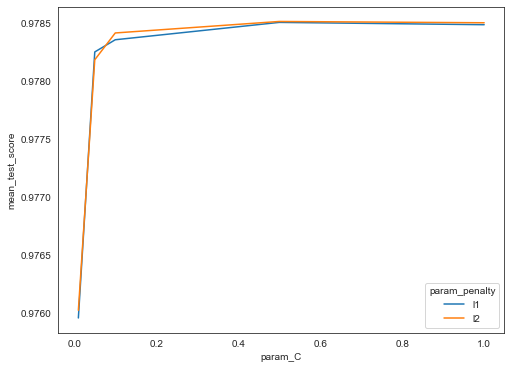

In [285]:
print(lr_gs1.best_params_)
cv_results_gs1 = pd.DataFrame(lr_gs1.cv_results_)
plt.figure(figsize=(8,6))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data = cv_results_gs1[cv_results_gs1['param_C']<=1])

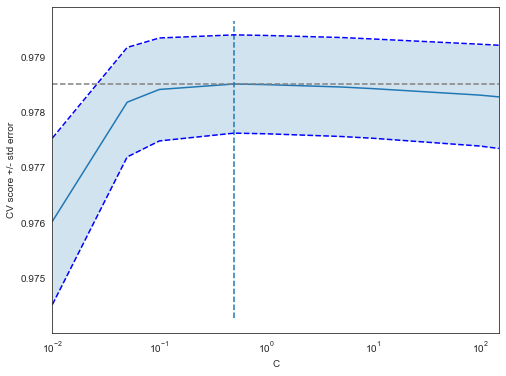

In [287]:
# Detailed results of grid search over penalty l1
best_params_gs1 = lr_gs1.best_params_['C']
scores_gs1 = cv_results_gs1[cv_results_gs1['param_penalty'] == 'l2']['mean_test_score']
std_error_gs1 = cv_results_gs1[cv_results_gs1['param_penalty'] == 'l2']['std_test_score']
alphas_gs1 = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 150])

grid_serach_dt(scores_gs1, std_error_gs1, alphas_gs1, best_params_gs1)

In [120]:
# Running the model with the best hyperparameters according with the grid search
lr_11 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')


# Fiting logistic regression
lr_11.fit(X_train, y_train)      

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   solver='liblinear')

In [121]:
# Function for predictions
def pred_with_reweight(model, X_train, X_test):
    # Predictions and probabilities for test and training
    y_h_tr = model.predict(X_train)
    y_h_tr_p = model.predict_proba(X_train)
    y_h_te = model.predict(X_test)
    y_h_te_p = model.predict_proba(X_test)
    
    # Reweigths of the probabilities
    q1 = y_train.sum()/len(y_train) # Proportions of 1
    r1 = 0.5 

    y_h_tr_p_rw = ft.reweight_proba(y_h_tr_p, q1, r1)
    y_h_te_p_rw = ft.reweight_proba(y_h_te_p, q1, r1)
    
    return y_h_tr_p_rw, y_h_te_p_rw, y_h_tr_p, y_h_te_p, y_h_tr, y_h_te

In [122]:
y_hat_train_p1, y_hat_test1, _, _, _, _ = pred_with_reweight(lr_11, X_train, X_test)

AUC:  0.9791300984136155


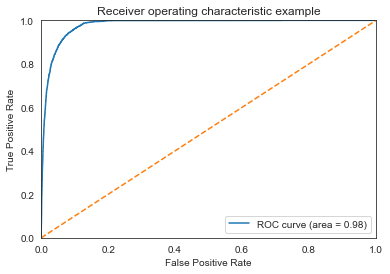

In [123]:
hf.get_auc(y_train, y_hat_train_p1, ['0','1'], column=1, plot=True)

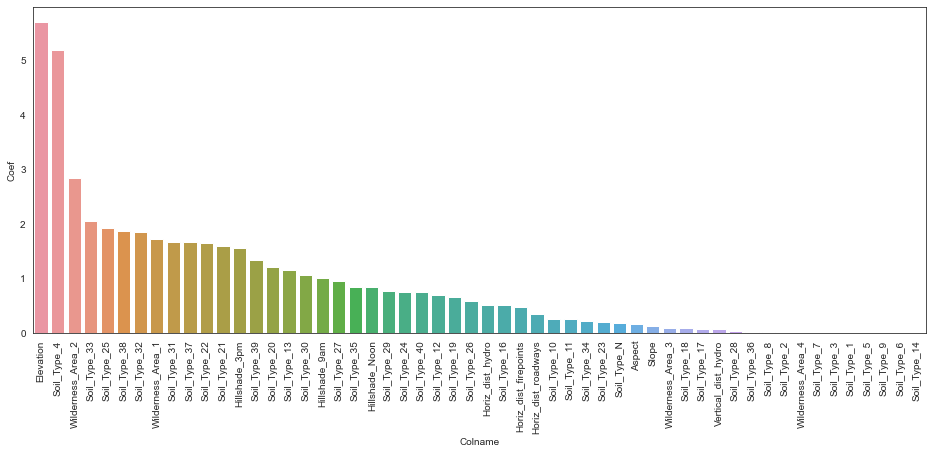

In [92]:
# Plot of variables impact
cp.col_import_plot(X_train.columns, lr_11.coef_.reshape(-1,))

In [16]:
# Saving the model and the data
joblib.dump(lr_11, 'models/lr_11.sav')

# Saving the data that the model uses
X_train.to_csv('data/output/lr_11_X_train.csv', index=False)
y_train.to_csv('data/output/lr_11_y_train.csv', index=False)
X_test.to_csv('data/output/lr_11_X_test.csv', index=False)

# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": X_test.index, "Cover_Type": y_hat_test1})
test_predictions_submit.to_csv("data/output/lr_11_y_hat_test.csv", index = False)

## Model 2

In [94]:
df3 = df2.copy()
print(df3.shape)
df3.head()

(74079, 15)


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type,From,target,Soil_Type_N
Index,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,3,38,train,0.0,38
1,3113,251,13,192,40,5600,191,249,195,2555,1,22,train,0.0,22
2,2801,77,9,510,17,1728,232,223,122,1087,1,12,train,0.0,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,29,train,0.0,29
4,3048,333,11,124,31,2823,196,226,170,666,1,23,train,0.0,23


In [95]:
# Polynomial features
poly_columns = ['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Soil_Type_N']

print(df3.shape)

df3 = ft.PolyFeatures(n_poly_f = 3).transform(df3.copy(), poly_columns)
print(df3.shape)
df3.head()

(74079, 15)
(74079, 37)


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Hillshade_9am_poly2,Hillshade_9am_poly3,Hillshade_Noon_poly2,Hillshade_Noon_poly3,Hillshade_3pm_poly2,Hillshade_3pm_poly3,Horiz_dist_firepoints_poly2,Horiz_dist_firepoints_poly3,Soil_Type_N_poly2,Soil_Type_N_poly3
Index,,,,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,...,47961,10503459,47524,10360232,17956,2406104,3006756,5213714904,1444,54872
1,3113,251,13,192,40,5600,191,249,195,2555,...,36481,6967871,62001,15438249,38025,7414875,6528025,16679103875,484,10648
2,2801,77,9,510,17,1728,232,223,122,1087,...,53824,12487168,49729,11089567,14884,1815848,1181569,1284365503,144,1728
3,3165,82,9,319,56,4890,233,225,124,1452,...,54289,12649337,50625,11390625,15376,1906624,2108304,3061257408,841,24389
4,3048,333,11,124,31,2823,196,226,170,666,...,38416,7529536,51076,11543176,28900,4913000,443556,295408296,529,12167


In [96]:
# Interaction but using also the dummies vars and the features aready scaled
y_train, X_train_2, X_test_2 = ft.build_y_X(df3, ['Wilderness_Area', 'Soil_Type'], 'target', 'From')
print(y_train.shape, X_train_2.shape, X_test_2.shape)

(61006,) (61006, 76) (13073, 76)


In [97]:
# Interactions between the most important columns according with Model 1
most_impor_cat_vars = ['Soil_Type_4', 'Wilderness_Area_2', 'Soil_Type_33', 'Soil_Type_25', 'Soil_Type_38',
'Soil_Type_32', 'Wilderness_Area_1', 'Soil_Type_31', 'Soil_Type_37', 'Soil_Type_22']

for col in most_impor_cat_vars:
    X_train_2['Ele_'+str(col)] = X_train_2['Elevation'] * X_train_2[col]
    X_test_2['Ele_'+str(col)] = X_test_2['Elevation'] * X_test_2[col]

print(X_train_2.shape)
print(X_test_2.shape)

(61006, 86)
(13073, 86)


In [ ]:
### Grid search

In [257]:
# Running the grid search
lr_2 = LogisticRegression( fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')

alphas = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])
#alphas = np.array([0.01, 0.05])

tuned_parameters = [{'penalty': ['l1','l2'], 'C': alphas}] 

n_folds = 5

lr_gs2 = GridSearchCV(lr_2, tuned_parameters, cv=n_folds, scoring='roc_auc', refit=False, verbose = 3)

In [258]:
lr_gs2.fit(X_train_2, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END .............................C=0.01, penalty=l1; total time=   3.4s
[CV 2/5] END .............................C=0.01, penalty=l1; total time=   3.2s
[CV 3/5] END .............................C=0.01, penalty=l1; total time=   4.3s
[CV 4/5] END .............................C=0.01, penalty=l1; total time=   4.1s
[CV 5/5] END .............................C=0.01, penalty=l1; total time=   3.3s
[CV 1/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 2/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 3/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 4/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 5/5] END .............................C=0.01, penalty=l2; total time=   0.7s
[CV 1/5] END .............................C=0.05, penalty=l1; total time=  22.4s
[CV 2/5] END .............................C=0.0

[CV 2/5] END ..............................C=1.0, penalty=l1; total time= 3.5min
[CV 3/5] END ..............................C=1.0, penalty=l1; total time= 3.6min
[CV 4/5] END ..............................C=1.0, penalty=l1; total time= 3.7min
[CV 5/5] END ..............................C=1.0, penalty=l1; total time= 3.2min
[CV 1/5] END ..............................C=1.0, penalty=l2; total time=   1.9s
[CV 2/5] END ..............................C=1.0, penalty=l2; total time=   2.0s
[CV 3/5] END ..............................C=1.0, penalty=l2; total time=   1.8s
[CV 4/5] END ..............................C=1.0, penalty=l2; total time=   1.7s
[CV 5/5] END ..............................C=1.0, penalty=l2; total time=   2.0s
[CV 1/5] END ..............................C=5.0, penalty=l1; total time= 6.8min
[CV 2/5] END ..............................C=5.0, penalty=l1; total time= 6.8min
[CV 3/5] END ..............................C=5.0, penalty=l1; total time= 5.0min
[CV 4/5] END ...............

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, solver='liblinear'),
             param_grid=[{'C': array([1.e-02, 5.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 1.e+00, 5.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1', 'l2']}],
             refit=False, scoring='roc_auc', verbose=3)

{'C': 5.0, 'penalty': 'l1'}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

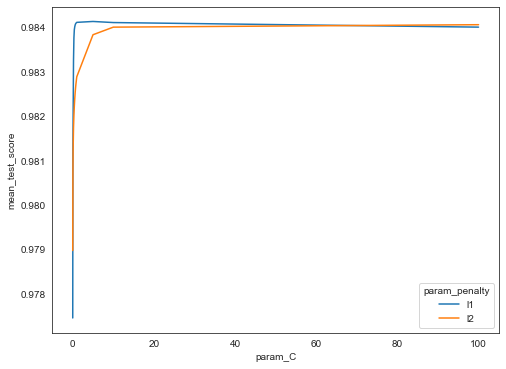

In [291]:
print(lr_gs2.best_params_)
cv_results_gs2 = pd.DataFrame(lr_gs2.cv_results_)
plt.figure(figsize=(8,6))
sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data = cv_results_gs2[cv_results_gs2['param_C']<1000])

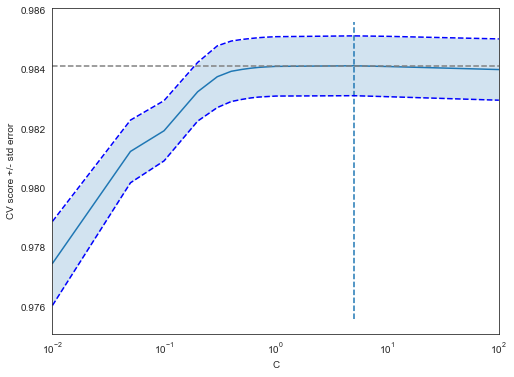

In [290]:
# Detailed reulst of grid search over penalty l1
best_params_gs2 = lr_gs2.best_params_['C']
scores_gs2 = cv_results_gs2[cv_results_gs2['param_penalty'] == 'l1']['mean_test_score']
std_error_gs2 = cv_results_gs2[cv_results_gs2['param_penalty'] == 'l1']['std_test_score']
alphas_gs2 = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 5, 10, 100])

cp.grid_serach_dt(scores_gs2, std_error_gs2, alphas_gs2, best_params_gs2)

In [261]:
# Running the model with the best hyperparameters according with the grid search
lr_21 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l1',
                           C = 5,
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=10000,
                           class_weight='balanced')


# Fiting logistic regression
lr_21.fit(X_train_2, y_train)      

LogisticRegression(C=5, class_weight='balanced', max_iter=10000, penalty='l1',
                   solver='liblinear')

In [262]:
# Predicted proba in test and training data
y_hat_train_p2, y_hat_test2, _, _, _, _ = pred_with_reweight(lr_21, X_train_2, X_test_2)

AUC:  0.9851007180700859


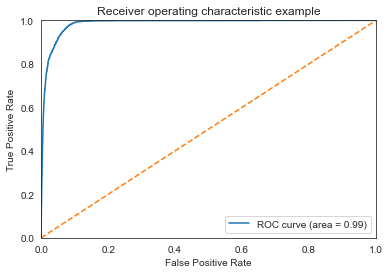

In [263]:
hf.get_auc(y_train, y_hat_train_p2, ['0','1'], column=1, plot=True)

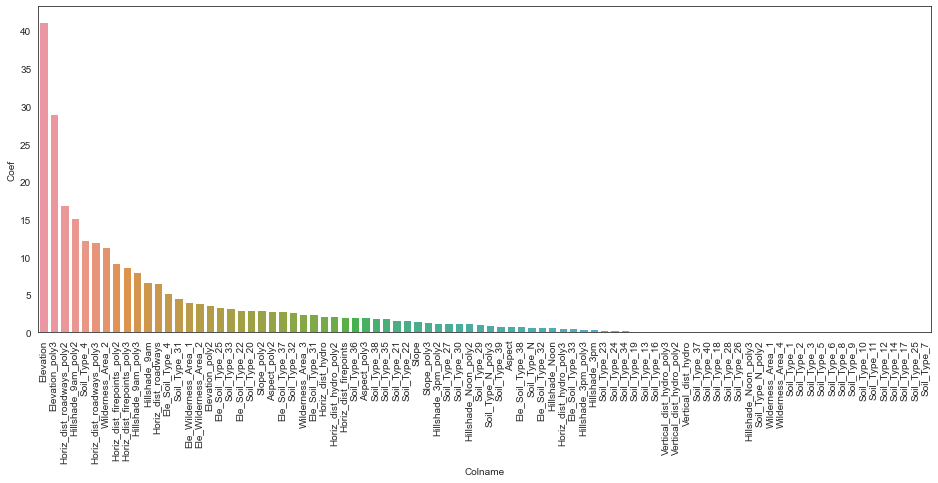

In [264]:
# Features importance
cp.col_import_plot(X_train_2.columns, lr_21.coef_.reshape(-1,))

In [267]:
# Saving the model and the data
joblib.dump(lr_21, 'models/lr_21.sav')

# Saving the data that the model uses
X_train_2.to_csv('data/output/lr_21_X_train.csv', index=False)
y_train.to_csv('data/output/lr_21_y_train.csv', index=False)
X_test_2.to_csv('data/output/lr_21_X_test.csv', index=False)

# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_hat_test2[:,1]})
test_predictions_submit.to_csv("data/output/lr_21_y_hat_test.csv", index = False)

# Multiclass classification

In [429]:
df_train = pd.read_csv('data/input/MultiClass_Train_index.csv')
df_test = pd.read_csv('data/input/MultiClass_Test.csv')

   Cover_Type  Cover_Type
2       29690   48.667344
1       22199   36.388224
3        3802    6.232174
7        2163    3.545553
6        1865    3.057076
5         992    1.626070
4         295    0.483559


<AxesSubplot:ylabel='Cover_Type'>

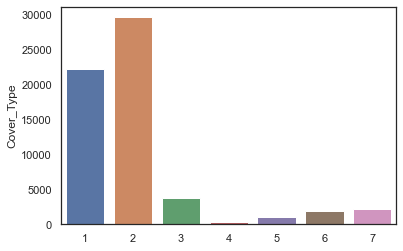

In [430]:
# Target variable
target_values = df_train['Cover_Type'].value_counts()
target_values_per = (df_train['Cover_Type'].value_counts()/df_train.shape[0]) * 100
df_multi_target = pd.concat([target_values, target_values_per],axis=1)
print(df_multi_target)
sns.barplot(x=target_values.index, y=target_values)

As we can see above the different classes of Cover Types are highly imbalanced, specialy the class 4 that represents less than 0.5% of the total rows of training data. On the contrary, cover type == 2 represents almost 50% of all of the observations in the data for training our model.

In [431]:
# Lets run a simple model , which will work as the base line model
# I will use the data used in the last model (model 2) for binaty task, adding the y multi class

print(X_train_2.shape)
X_train_3 = pd.merge(X_train_2,  df_train.set_index('Index')['Cover_Type'], left_index = True, right_index = True) 
print(X_train_3.shape)

# Go back by creating y and droping Cove_type
y_train_m = X_train_3['Cover_Type']
X_train_3.drop('Cover_Type', axis=1, inplace=True)

print(X_train_3.shape, X_train_2.shape, y_train_m.shape)

(61006, 86)
(61006, 87)
(61006, 86) (61006, 86) (61006,)


In [344]:
lr_31 = LogisticRegression(fit_intercept=True, 
                           penalty = 'l2',
                           C = 0.5,
                           multi_class="multinomial",
                           intercept_scaling=1, 
                           solver='newton-cg', 
                           max_iter=10000,
                           class_weight='balanced')

# Fiting logistic regression
lr_31.fit(X_train_3, y_train_m)   

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

1    21747
2    19801
5     7077
7     4781
6     3450
3     3319
4      831
dtype: int64


<AxesSubplot:>

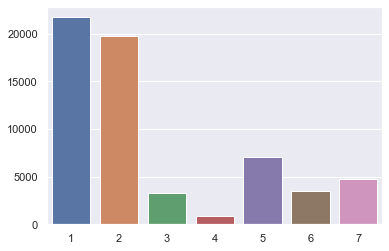

In [345]:
# Default class predictions on training data
y_h_train3_m_v = pd.Series(lr_31.predict(X_train_3))
y_h_train3_m_v_vc = y_h_train3_m_v.value_counts()
print(y_h_train3_m_v_vc)
sns.barplot(x=y_h_train3_m_v_vc.index, y=y_h_train3_m_v_vc)

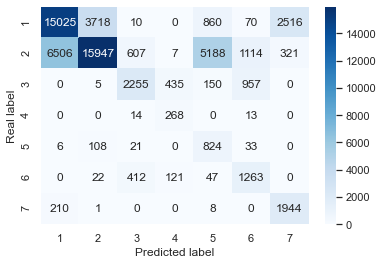

In [346]:
cm =  confusion_matrix(y_pred=y_h_train3_m_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) ## From the utils folder class lables are class_labels = ["email","spam"]

In [347]:
y_h_train3_m = lr_31.predict_proba(X_train_3)
y_h_test3_m = lr_31.predict_proba(X_test_2)

In [348]:
def reweight_proba_multy(pi, q, r):
    pi_rw = pi.copy()
    tot = np.dot(pi, (np.array(q)/r))
    for i in range(len(q)):
        pi_rw[:,i] = (pi[:,i] * q[i]/r) / tot
    return pi_rw

In [326]:
target_values_per/100

2    0.486673
1    0.363882
3    0.062322
7    0.035456
6    0.030571
5    0.016261
4    0.004836
Name: Cover_Type, dtype: float64

In [412]:
q = [0.363882, 0.486673, 0.062322, 0.004836, 0.016261, 0.030571, 0.035456]
r = 1/7

y_h_train3_m_rw = reweight_proba_multy(y_h_train3_m, q, r)

(61006, 7)
[1. 1. 1. ... 1. 1. 1.]


In [469]:
# Turn probabilities into values
def prob_to_value(prob, classes):
    values = []
    df_prob = pd.DataFrame(prob.T, index=classes)
    for col in df_prob.columns:
        values.append(df_prob[col].idxmax())
    return values

2    30788
1    22374
3     4504
7     1648
6     1335
4      206
5      151
dtype: int64


<AxesSubplot:>

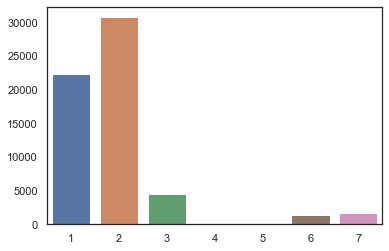

In [472]:
# Assign class labes according with the probabilities
y_h_train3_m_rw_v = pd.Series(prob_to_value(y_h_train3_m_rw, [1,2,3,4,5,6,7]))
y_h_train3_m_rw_v_vc = y_h_train3_m_rw_v.value_counts()
print(y_h_train3_m_rw_v_vc)
sns.barplot(x=y_h_train3_m_rw_v_vc.index, y=y_h_train3_m_rw_v_vc)

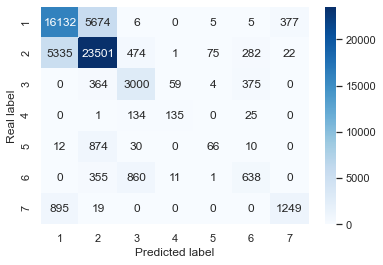

In [473]:
cm =  confusion_matrix(y_pred=y_h_train3_m_rw_v, y_true=y_train_m, labels=[1,2,3,4,5,6,7]) 
hf.plot_confusion_matrix(cm, [1,2,3,4,5,6,7]) ## From the utils folder class lables are class_labels = ["email","spam"]

In [474]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

y = label_binarize(y_train_m, classes=[1, 2, 3, 4, 5, 6, 7])
print(np.sum(y, axis=0))
print(y.shape, y_h_train3_m_rw.shape)

[22199 29690  3802   295   992  1865  2163]
(61006, 7) (61006, 7)


In [475]:
y_prob = y_h_train3_m_rw
y_test = y

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.944303 (macro),
0.878190 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.944303 (macro),
0.878190 (weighted by prevalence)


2    6586
1    4819
3     917
7     349
6     320
4      48
5      34
dtype: int64


<AxesSubplot:>

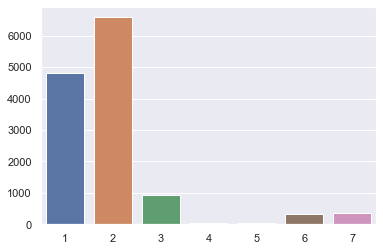

In [478]:
# Reweight and get the values in the test data
y_h_test3_m_rw = reweight_proba_multy(y_h_test3_m, q, r)

y_h_test3_m_rw_v = pd.Series(prob_to_value(y_h_test3_m_rw, [1,2,3,4,5,6,7]))
y_h_test3_m_rw_v_vc = y_h_test3_m_rw_v.value_counts()

print(y_h_test3_m_rw_v_vc)
sns.barplot(x=y_h_test3_m_rw_v_vc.index, y=y_h_test3_m_rw_v_vc)

In [480]:
# Saving the model and the data
joblib.dump(lr_31, 'models/lr_31.sav')

# Saving the data that the model uses
X_train_3.to_csv('data/output/lr_31_X_train.csv', index=False)
y_train_m.to_csv('data/output/lr_31_y_train.csv', index=False)
X_test_2.to_csv('data/output/lr_31_X_test.csv', index=False)

# Produce .csv for kaggle  
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test3_m_rw_v})
test_predictions_submit.to_csv("data/output/lr_31_y_hat_test.csv", index = False)

In [428]:
# Lets submit the predictions without reweight the probabilities
y_h_test3_m_v = lr_31.predict(X_test_2)
print(pd.Series(y_h_test3_m_v).value_counts())
test_predictions_submit = pd.DataFrame({"Index": X_test_2.index, "Cover_Type": y_h_test3_m_v})
test_predictions_submit.to_csv("data/output/lr_31_y_hat_test2.csv", index = False)

1    4688
2    4325
5    1467
7     994
6     754
3     665
4     180
dtype: int64
